# Transcriptomic subtypes relationship to cell proportions in Schildkraut HGSOC

We hypothesized that the four TCGA-style consensusOV transcriptomic subtypes encode distinct cellular ecosystems. After consesnsusOV assignment of 588 tumours, we got Immunoreactive = 173, Differentiated = 180, Mesenchymal = 132, Proliferative = 103 samples.  We then used omnibus one-way ANOVAs on logit-transformed fractions, followed by Tukey HSD contrasts to test the relationships. 

**Results**

All four macro fractions differed across the four subtypes, each retaining significance after Bonferroni correction: epithelial (F = 50.935, p-adj < 1.19 × 10⁻28), adipocyte (F = 43.193, p-adj = 1.28 × 10⁻24), immune (F = 33.335, p-adj = 2.69 × 10⁻19) and stromal fractions (F =  5.526, p-adj = 3.83 × 10⁻3). Further Turkey post-hoc contrasts showed a coherent pattern, as seen in Fig. 4e of the paper:

•	Immunoreactive tumours were immune-rich and carried the lowest adipocyte load.

•	Mesenchymal tumours were the most stromal- and adipocyte-enriched, with significantly fewer epithelial cells than the Proliferative group.

•	Proliferative tumours were dominated by epithelial/tumour cells and had the sparsest immune infiltrate.

•	Differentiated tumours occupied an intermediate position for all three non-epithelial compartments.

Each subtype displayed a unique signature, affirming that bulk cell composition captures meaningful biological differences among subtypes, further strengthening the idea that the transcriptomic subtypes are cell-composition based.


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns, matplotlib.pyplot as plt
import os
import itertools
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")
sys.path.insert(1, "../../../")

import src.hp as hp
import src.params as params

np.random.seed(88)

## Parameters

In [3]:
fractions = params.fractions
subtype_order = params.subtype_order
subtype_map = params.subtype_map
cont_cols = params.cont_cols
custom_colors = params.custom_colors
colors = params.colors

## Paths

In [4]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

subB = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv",
)
subW = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv",
)

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [5]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


### Build the analysis table  (clinical + cell fractions)


In [6]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()

Metadata

In [7]:
meta_full = hp.open_and_clean_meta(
    meta_path=meta_path, renaming=renaming, tissue_dictionary=tissue_dictionary
)

In [8]:
# match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [
    col for col in df.columns if col not in meta_full.columns and col not in cont_cols
]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [9]:
# ─────────────────────────────────────────────────────────────────────────
# Processing clustering too (subtypes)
# ─────────────────────────────────────────────────────────────────────────
subB = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv",
)
subW = os.path.join(
    base_path,
    "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv",
)
subtypeB = pd.read_csv(subB, index_col=0)
subtypeW = pd.read_csv(subW, index_col=0)
subtypeW["ID"] = subtypeW.index
subtypeB["ID"] = subtypeB.index
subtypeB

,consensusOVsubtype,Dataset,ID
ID,,,
18341X10,DIF_consensus,SchildkrautB,18341X10
18341X12,PRO_consensus,SchildkrautB,18341X12
18341X13,DIF_consensus,SchildkrautB,18341X13
18341X14,IMR_consensus,SchildkrautB,18341X14
18341X15,PRO_consensus,SchildkrautB,18341X15
...,...,...,...
19291X94,MES_consensus,SchildkrautB,19291X94
19291X95,DIF_consensus,SchildkrautB,19291X95
19291X97,IMR_consensus,SchildkrautB,19291X97


In [10]:
map_black = pd.read_csv(
    os.path.join(base_path, "input_data/sample_metadata.tsv"), sep="\t"
)
map_white = pd.read_csv(
    os.path.join(base_path, "input_data/sample_metadata_whites.tsv"), sep="\t"
)

mapping = (
    pd.concat([map_black, map_white], ignore_index=True)
    .loc[:, ["suid", "ID"]]  # keep only key columns
    .rename(columns={"ID": "SampleID"})
)
mapping["suid"] = (
    mapping["suid"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)  # keep digits
    .astype(int)
)

mapping_dict = dict(zip(mapping["SampleID"], mapping["suid"]))
mapping_dict

{'19291X44': 110149,
 '19291X46': 110188,
 '19291X47': 110190,
 '19291X49': 110203,
 '19291X50': 110206,
 '19291X52': 110209,
 '19291X53': 110210,
 '19291X54': 110211,
 '19291X55': 110212,
 '19291X56': 110221,
 '19291X58': 110230,
 '19291X59': 110232,
 '19291X60': 110234,
 '19291X63': 110246,
 '19291X64': 110247,
 '19291X65': 110248,
 '19291X67': 110250,
 '19291X68': 110251,
 '19291X70': 110271,
 '19291X71': 110275,
 '19291X72': 110288,
 '19291X74': 110290,
 '19291X75': 110291,
 '19291X76': 110295,
 '19291X77': 110299,
 '19291X78': 110301,
 '19291X79': 110304,
 '19291X80': 110307,
 '19291X81': 110308,
 '19291X82': 110311,
 '19291X83': 110318,
 '19291X84': 110324,
 '19291X86': 110340,
 '19291X87': 110341,
 '19291X88': 110347,
 '19291X90': 110350,
 '19291X92': 110361,
 '19291X94': 110363,
 '19291X95': 110369,
 '19291X97': 110380,
 '19291X98': 110382,
 '19291X99': 110385,
 '19291X100': 110392,
 '19291X101': 110393,
 '19291X102': 110394,
 '19291X103': 110403,
 '19291X104': 110404,
 '19291X

In [11]:
subtypeB["ID"] = subtypeB.ID.map(mapping_dict)
subtypeW["ID"] = subtypeW.ID.map(mapping_dict)

subtypes = pd.concat([subtypeB, subtypeW], axis=0, ignore_index=True)
subtypes = subtypes.reset_index()

# This sample has an extra 0, cut off at some point in previous processing.
# We'll fix here manually:
index = subtypes[subtypes["ID"] == 427730].index
subtypes.loc[index, "ID"] = 42773  # correct it

df.drop(columns=["ID"], inplace=True)
df = df.merge(subtypes, on="ID")

df["Subtype"] = df["consensusOVsubtype"].map(subtype_map)
df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset_x,index,consensusOVsubtype,Dataset_y,Subtype
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW,305,IMR_consensus,SchildkrautW,Immunoreactive
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW,458,DIF_consensus,SchildkrautW,Differentiated
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB,24,IMR_consensus,SchildkrautB,Immunoreactive
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW,459,DIF_consensus,SchildkrautW,Differentiated
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW,499,IMR_consensus,SchildkrautW,Immunoreactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB,206,MES_consensus,SchildkrautB,Mesenchymal
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB,209,DIF_consensus,SchildkrautB,Differentiated
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB,210,PRO_consensus,SchildkrautB,Proliferative
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,1.468406e-104,1.306579e-17,3.022363e-131,0.0,0.205731,SchildkrautB,211,IMR_consensus,SchildkrautB,Immunoreactive


## We'll plot per cell type grouping, just to visualize.

Plasma cells


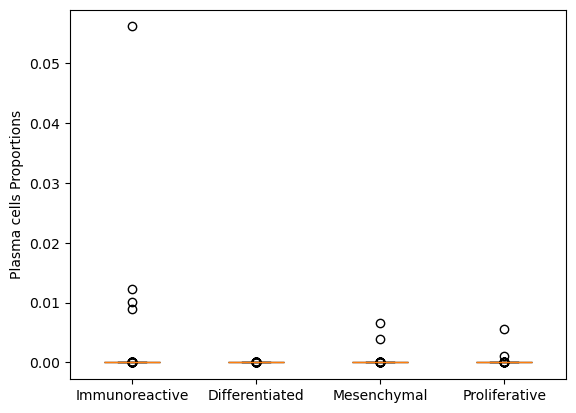

B cells


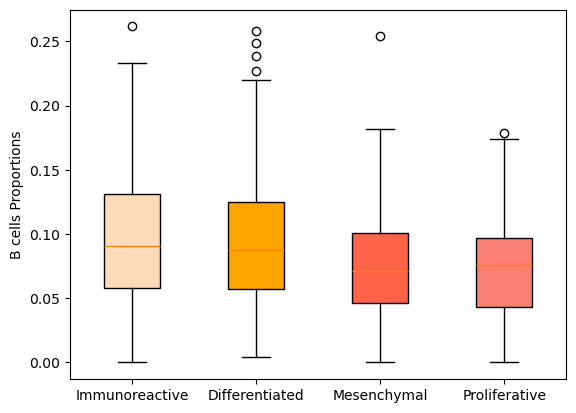

Endothelial cells


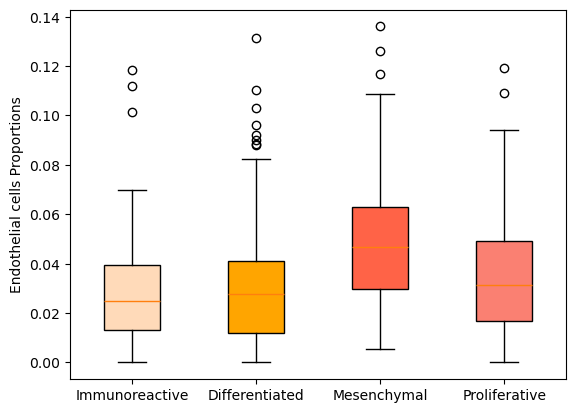

T cells


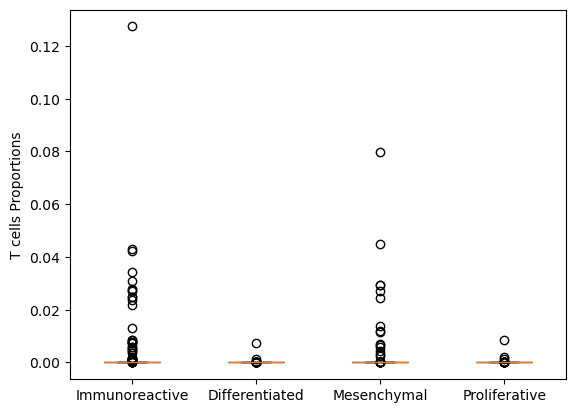

Monocytes


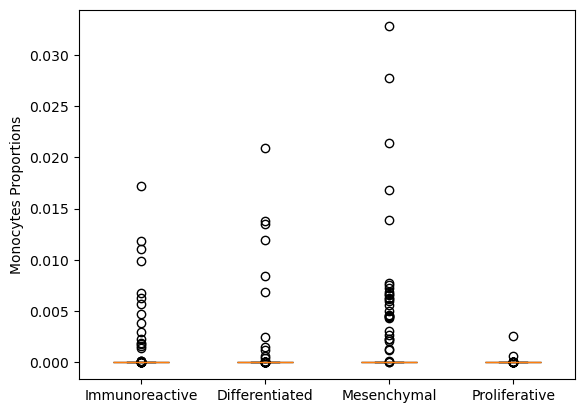

Fibroblasts


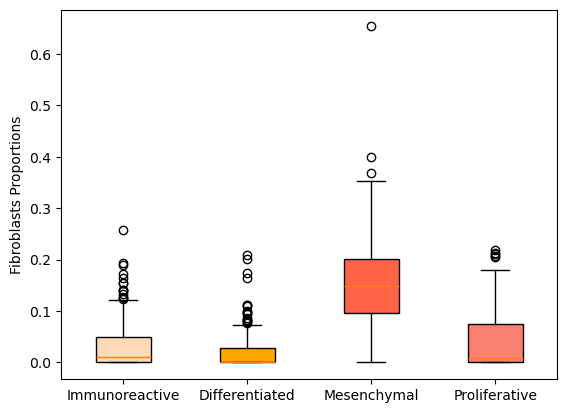

NK cells


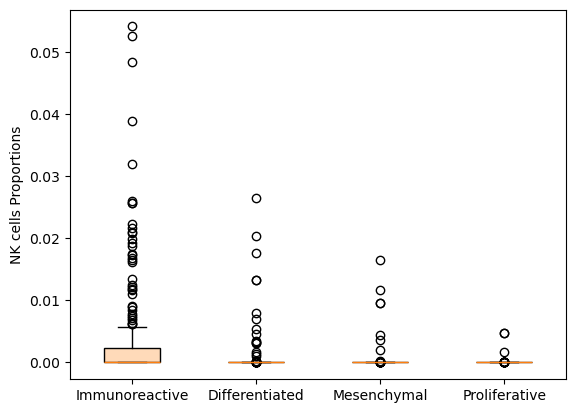

Epithelial cells


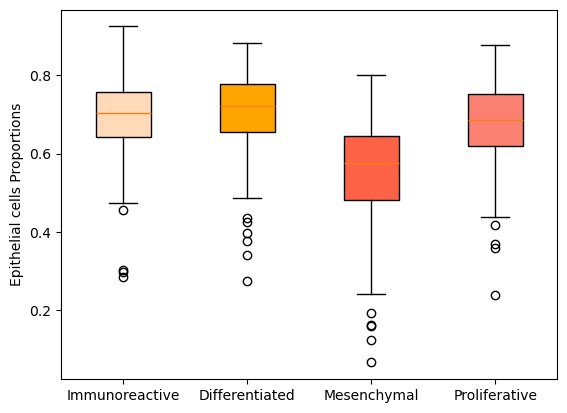

DC


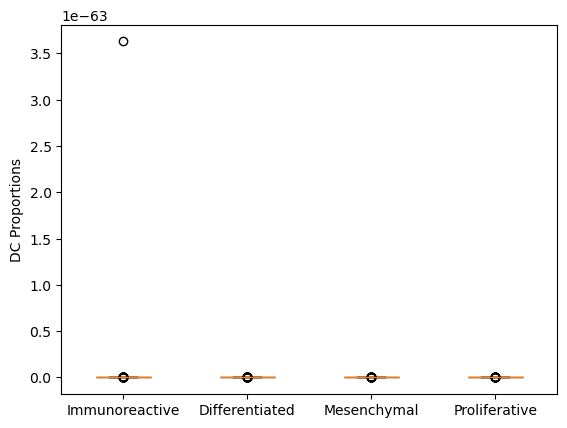

pDC


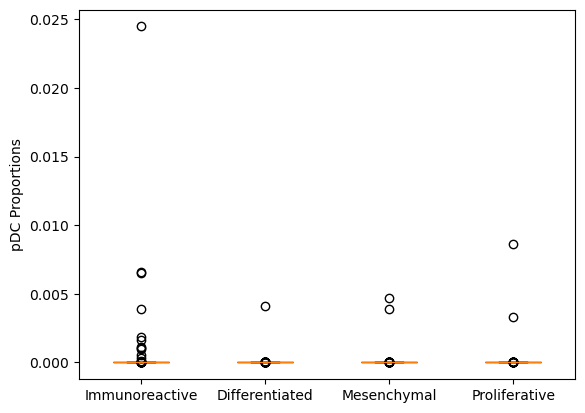

ILC


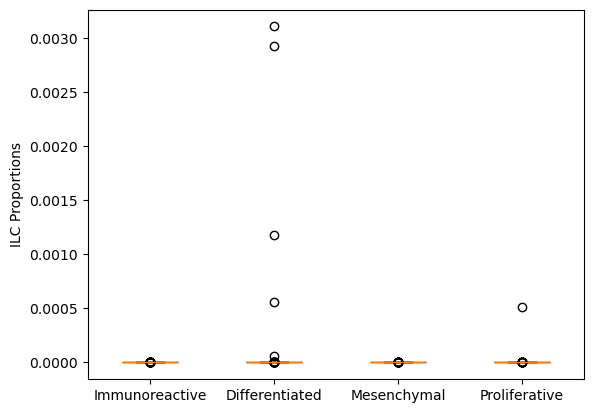

Macrophages


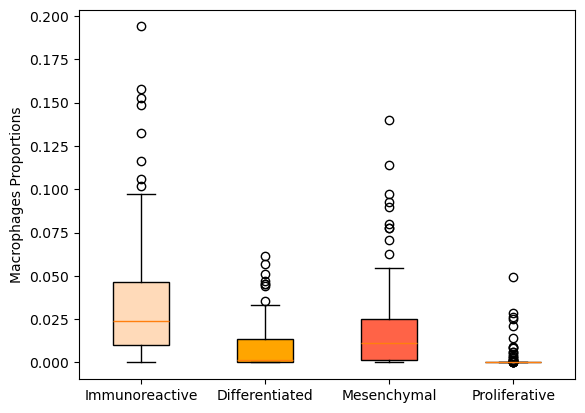

Mast cells


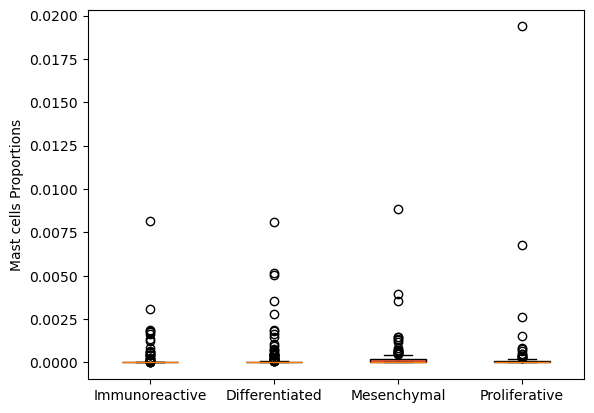

Erythroid


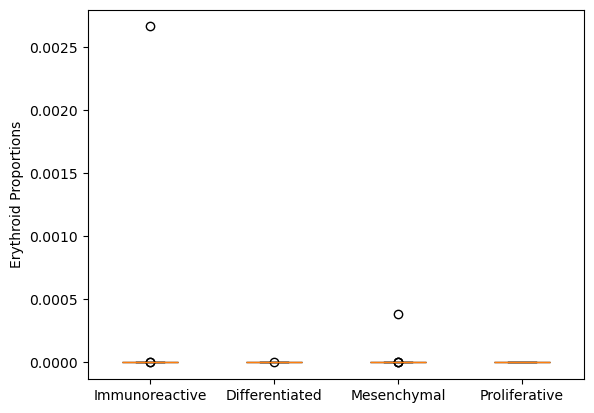

Adipocytes


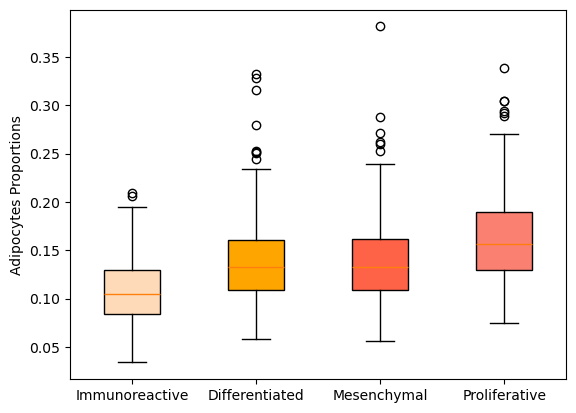

In [12]:
subtype_list = list(subtype_map.values())
labels = subtype_list

for cell in cell_types:
    print(cell)

    om = df[df.Subtype == subtype_list[0]][cell]
    ov = df[df.Subtype == subtype_list[1]][cell]
    ovft = df[df.Subtype == subtype_list[2]][cell]
    ft = df[df.Subtype == subtype_list[3]][cell]

    values = [om, ov, ovft, ft]

    fig, ax = plt.subplots()
    ax.set_ylabel(f"{cell} Proportions")

    bplot = ax.boxplot(
        values, patch_artist=True, tick_labels=labels  # fill with color
    )  # will be used to label x-ticks

    # fill with colors
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

    plt.show()

Now by group:

In [13]:
## Which cell types to use
immune_cells = [
    "B cells",
    "Mast cells",
    "T cells",
    "Monocytes",
    "Plasma cells",
    "NK cells",
    "DC",
    "pDC",
    "Macrophages",
    "ILC",
]

stromal_cells = ["Fibroblasts", "Endothelial cells"]

df["Immune"] = df[immune_cells].sum(axis=1)
df["Stromal"] = df[stromal_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,Erythroid,Adipocytes,Dataset_x,index,consensusOVsubtype,Dataset_y,Subtype,Immune,Stromal,Epithelial
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,0.0,0.113422,SchildkrautW,305,IMR_consensus,SchildkrautW,Immunoreactive,0.218528,5.741863e-02,0.610632
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,0.0,0.169611,SchildkrautW,458,DIF_consensus,SchildkrautW,Differentiated,0.096819,3.138082e-02,0.702189
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,0.0,0.064832,SchildkrautB,24,IMR_consensus,SchildkrautB,Immunoreactive,0.086715,1.228492e-01,0.725604
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,0.0,0.119373,SchildkrautW,459,DIF_consensus,SchildkrautW,Differentiated,0.107769,1.118747e-01,0.660983
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,0.0,0.110333,SchildkrautW,499,IMR_consensus,SchildkrautW,Immunoreactive,0.087462,6.225249e-02,0.739953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,0.0,0.097551,SchildkrautB,206,MES_consensus,SchildkrautB,Mesenchymal,0.049467,7.507748e-02,0.777904
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,0.0,0.135411,SchildkrautB,209,DIF_consensus,SchildkrautB,Differentiated,0.093217,9.157968e-51,0.771372
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,0.0,0.181209,SchildkrautB,210,PRO_consensus,SchildkrautB,Proliferative,0.134981,2.364402e-02,0.660166
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,0.0,0.205731,SchildkrautB,211,IMR_consensus,SchildkrautB,Immunoreactive,0.201393,2.243354e-02,0.570443


## Subtype × Adipocyte / Immune / Stromal – logit-transform ANOVA + Bonferroni

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# keep rows with non-missing Subtype, add logit-transformed columns
# ─────────────────────────────────────────────────────────────────────────────
df_sub = df.dropna(subset=["Subtype"]).copy()
print("Subtype counts:\n", df_sub["Subtype"].value_counts())

for frac in fractions:
    p = df_sub[frac]
    df_sub[f"logit_{frac}"] = np.log(p / (1 - p))

# ─────────────────────────────────────────────────────────────────────────────
# Omnibus ANOVA on logit-scaled fractions
# ─────────────────────────────────────────────────────────────────────────────
# define your four groups explicitly
levels = subtype_order.copy()

rows = []
for frac in fractions:
    col = f"logit_{frac}"  # run ANOVA on the logit scale
    groups = [df_sub.loc[df_sub["Subtype"] == lvl, col].dropna() for lvl in levels]
    # sanity check: all groups must have >= 2 points
    lengths = [len(g) for g in groups]
    print(f"{frac} group sizes: {dict(zip(levels,lengths))}")

    f_stat, p_val = f_oneway(*groups)
    print(f"{frac}: F = {f_stat:.3f}, p = {p_val:.3e}\n")
    rows.append({"Fraction": frac, "p_raw": p_val})

# then Bonferroni‐correct just as before
res = pd.DataFrame(rows)
res["p_bonf"] = multipletests(res.p_raw, method="bonferroni")[1]
res = res.sort_values("p_bonf")

print("\n=== Omnibus ANOVA on logit fractions (Bonferroni sorted) ===")
display(res)

Subtype counts:
 Subtype
Differentiated    179
Immunoreactive    175
Mesenchymal       130
Proliferative     104
Name: count, dtype: int64
Adipocytes group sizes: {'Immunoreactive': 175, 'Differentiated': 179, 'Mesenchymal': 130, 'Proliferative': 104}
Adipocytes: F = 43.193, p = 3.206e-25

Immune group sizes: {'Immunoreactive': 175, 'Differentiated': 179, 'Mesenchymal': 130, 'Proliferative': 104}
Immune: F = 33.335, p = 6.722e-20

Stromal group sizes: {'Immunoreactive': 175, 'Differentiated': 179, 'Mesenchymal': 130, 'Proliferative': 104}
Stromal: F = 5.526, p = 9.565e-04

Epithelial group sizes: {'Immunoreactive': 175, 'Differentiated': 179, 'Mesenchymal': 130, 'Proliferative': 104}
Epithelial: F = 50.935, p = 2.967e-29


=== Omnibus ANOVA on logit fractions (Bonferroni sorted) ===


,Fraction,p_raw,p_bonf
3,Epithelial,2.967338e-29,1.186935e-28
0,Adipocytes,3.205874e-25,1.282350e-24
1,Immune,6.722196e-20,2.688878e-19
2,Stromal,9.565465e-04,3.826186e-03


In [15]:
# ---------- 1.  Tukey–HSD results into dict ---------------------------------
tukey_dict = {}
for frac in fractions:
    res_ = pairwise_tukeyhsd(
        endog=df_sub[f"logit_{frac}"], groups=df_sub["Subtype"], alpha=0.05
    )
    tuk = pd.DataFrame(res_.summary().data[1:], columns=res_.summary().data[0])
    tukey_dict[frac] = tuk

# ---------- 3.  long data for raw proportions (for boxes & y-max) ------------
long_all = df_sub[["Subtype"] + fractions].melt(
    id_vars="Subtype", var_name="Fraction", value_name="Prop"
)
long_all["Subtype"] = pd.Categorical(
    long_all["Subtype"], categories=subtype_order, ordered=True
)
long_all

,Subtype,Fraction,Prop
0,Immunoreactive,Adipocytes,0.113422
1,Differentiated,Adipocytes,0.169611
2,Immunoreactive,Adipocytes,0.064832
3,Differentiated,Adipocytes,0.119373
4,Immunoreactive,Adipocytes,0.110333
...,...,...,...
2347,Mesenchymal,Epithelial,0.777904
2348,Differentiated,Epithelial,0.771372
2349,Proliferative,Epithelial,0.660166
2350,Immunoreactive,Epithelial,0.570443


## This plot will show us if there are differences within each subtype (not what is different)

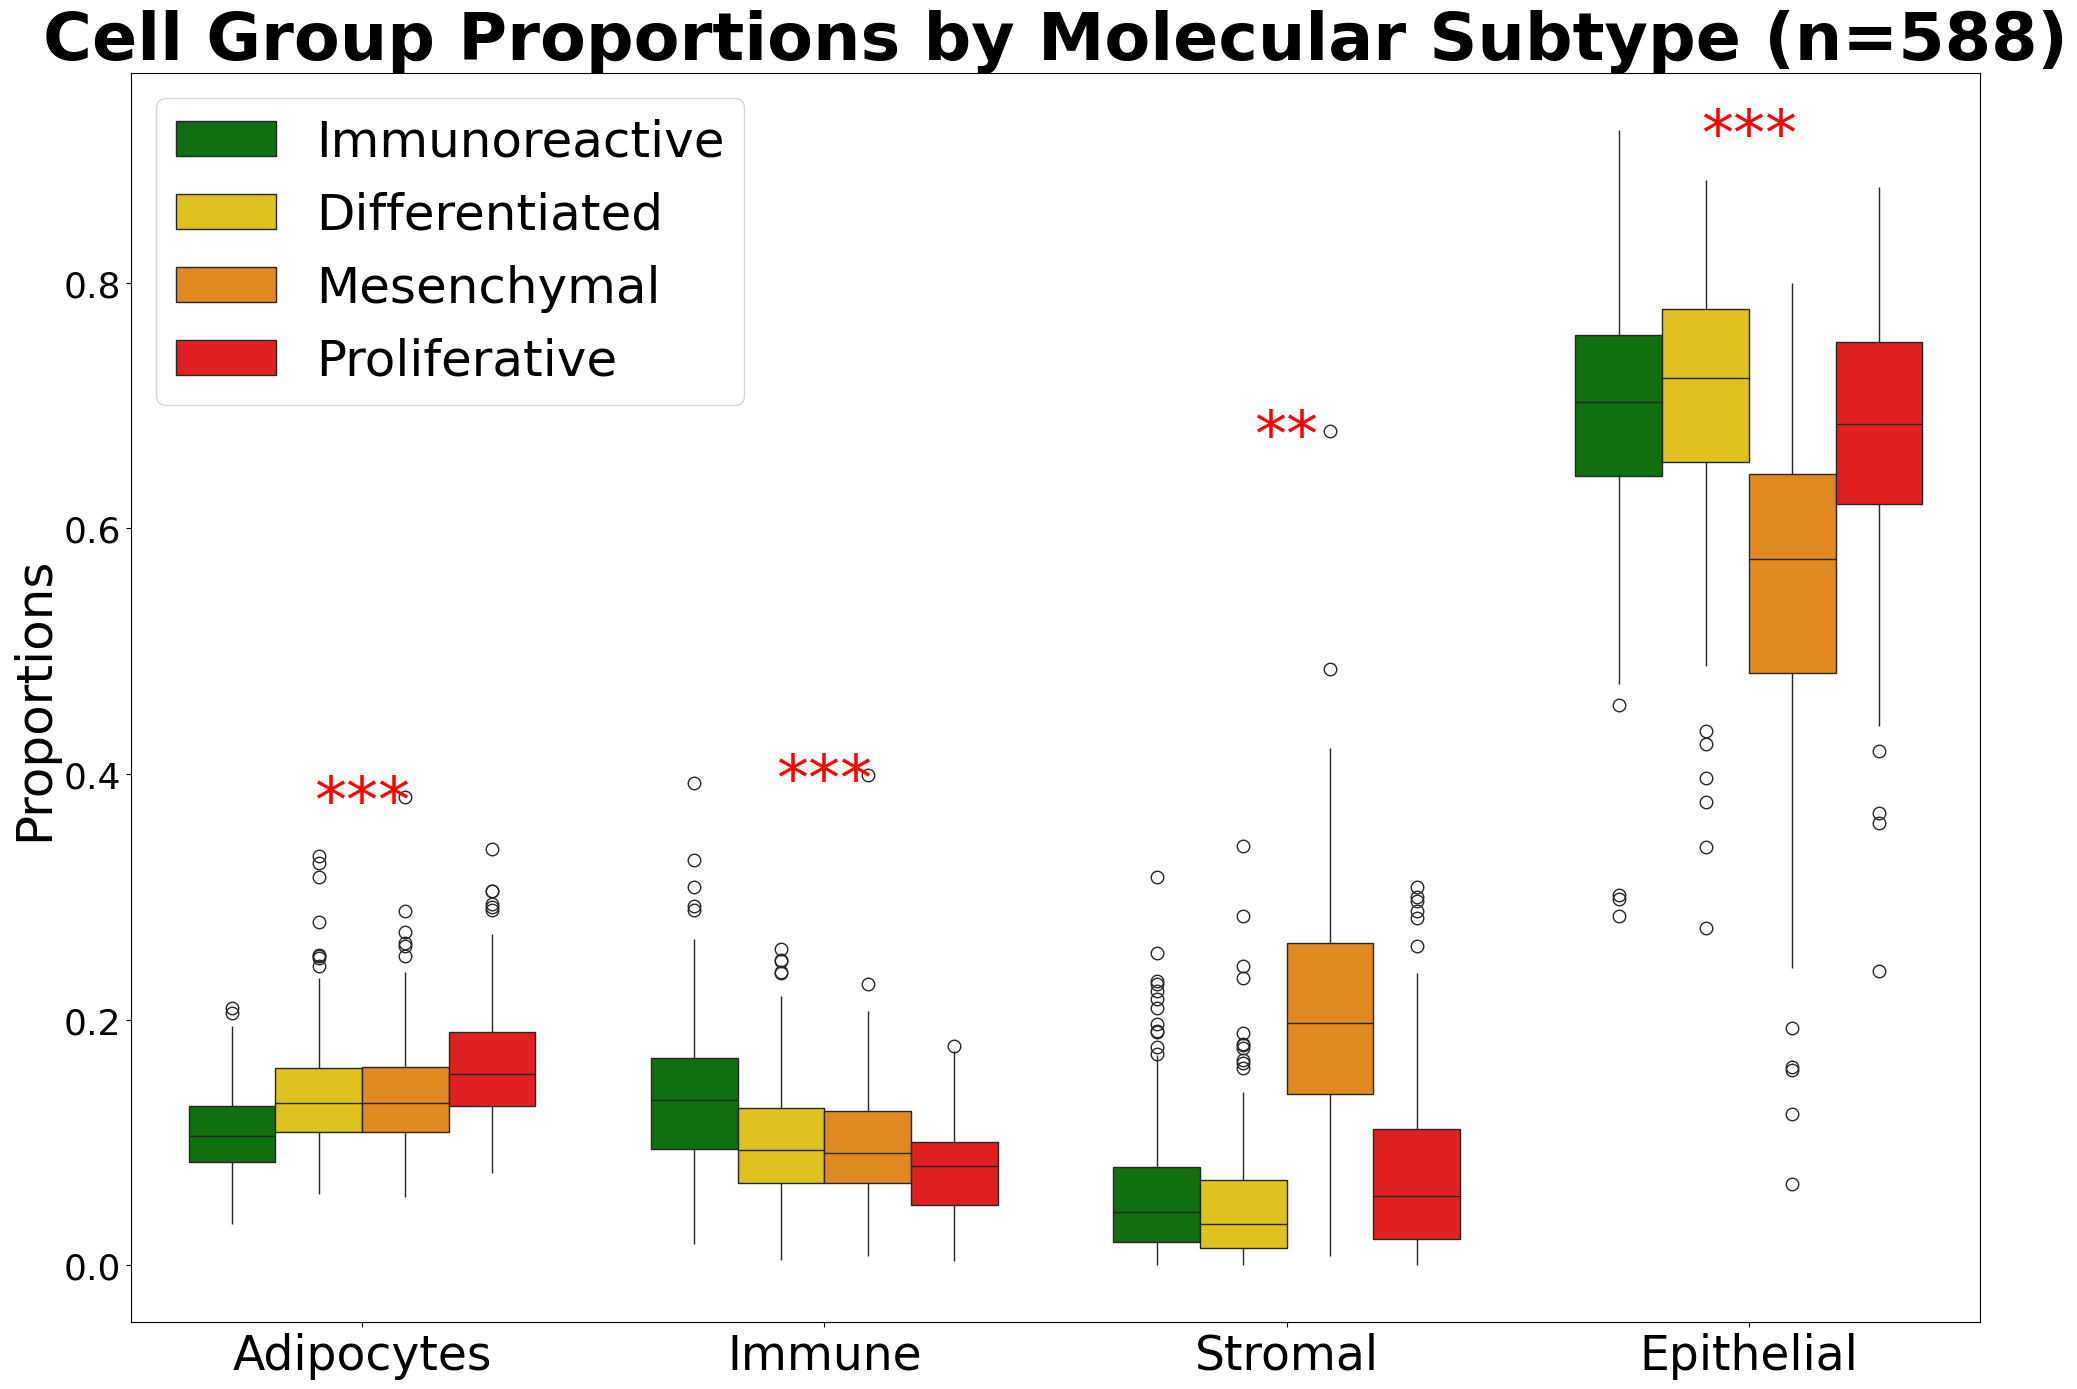

In [16]:
# colour palette for the four subtypes into a palette
palette = dict(zip(subtype_order, custom_colors))

# --- plot -------------------------------------------------------------------
plt.figure(figsize=(20, 14))
ax = sns.boxplot(
    data=long_all,
    x="Fraction",
    y="Prop",
    hue="Subtype",
    palette=palette,
    width=0.75,
    showcaps=False,
    fliersize=9,
)

# significance stars from the omnibus table
for i, frac in enumerate(fractions):
    star = hp.p_to_star(res.loc[res.Fraction == frac, "p_bonf"].values[0])
    if star:
        y_max = long_all.loc[long_all.Fraction == frac, "Prop"].max() - 0.05
        ax.text(
            i, y_max + 0.02, star, ha="center", va="bottom", color="red", fontsize=46
        )

plt.ylabel("Proportions", fontsize=36)
plt.xlabel("", fontsize=36)
plt.title(
    f"Cell Group Proportions by Molecular Subtype (n={df.shape[0]})",
    fontsize=48,
    fontweight="bold",
)
plt.legend(title="", fontsize=24, loc="best")
plt.xticks(fontsize=34)
plt.yticks(fontsize=26)

# clean legend
handles, labels = ax.get_legend_handles_labels()
order = [labels.index(s) for s in subtype_order if s in labels]
ax.legend([handles[i] for i in order], subtype_order, fontsize=36, loc="best")

plt.tight_layout()
plt.show()

## This plot will show us what cell gorup is different to which

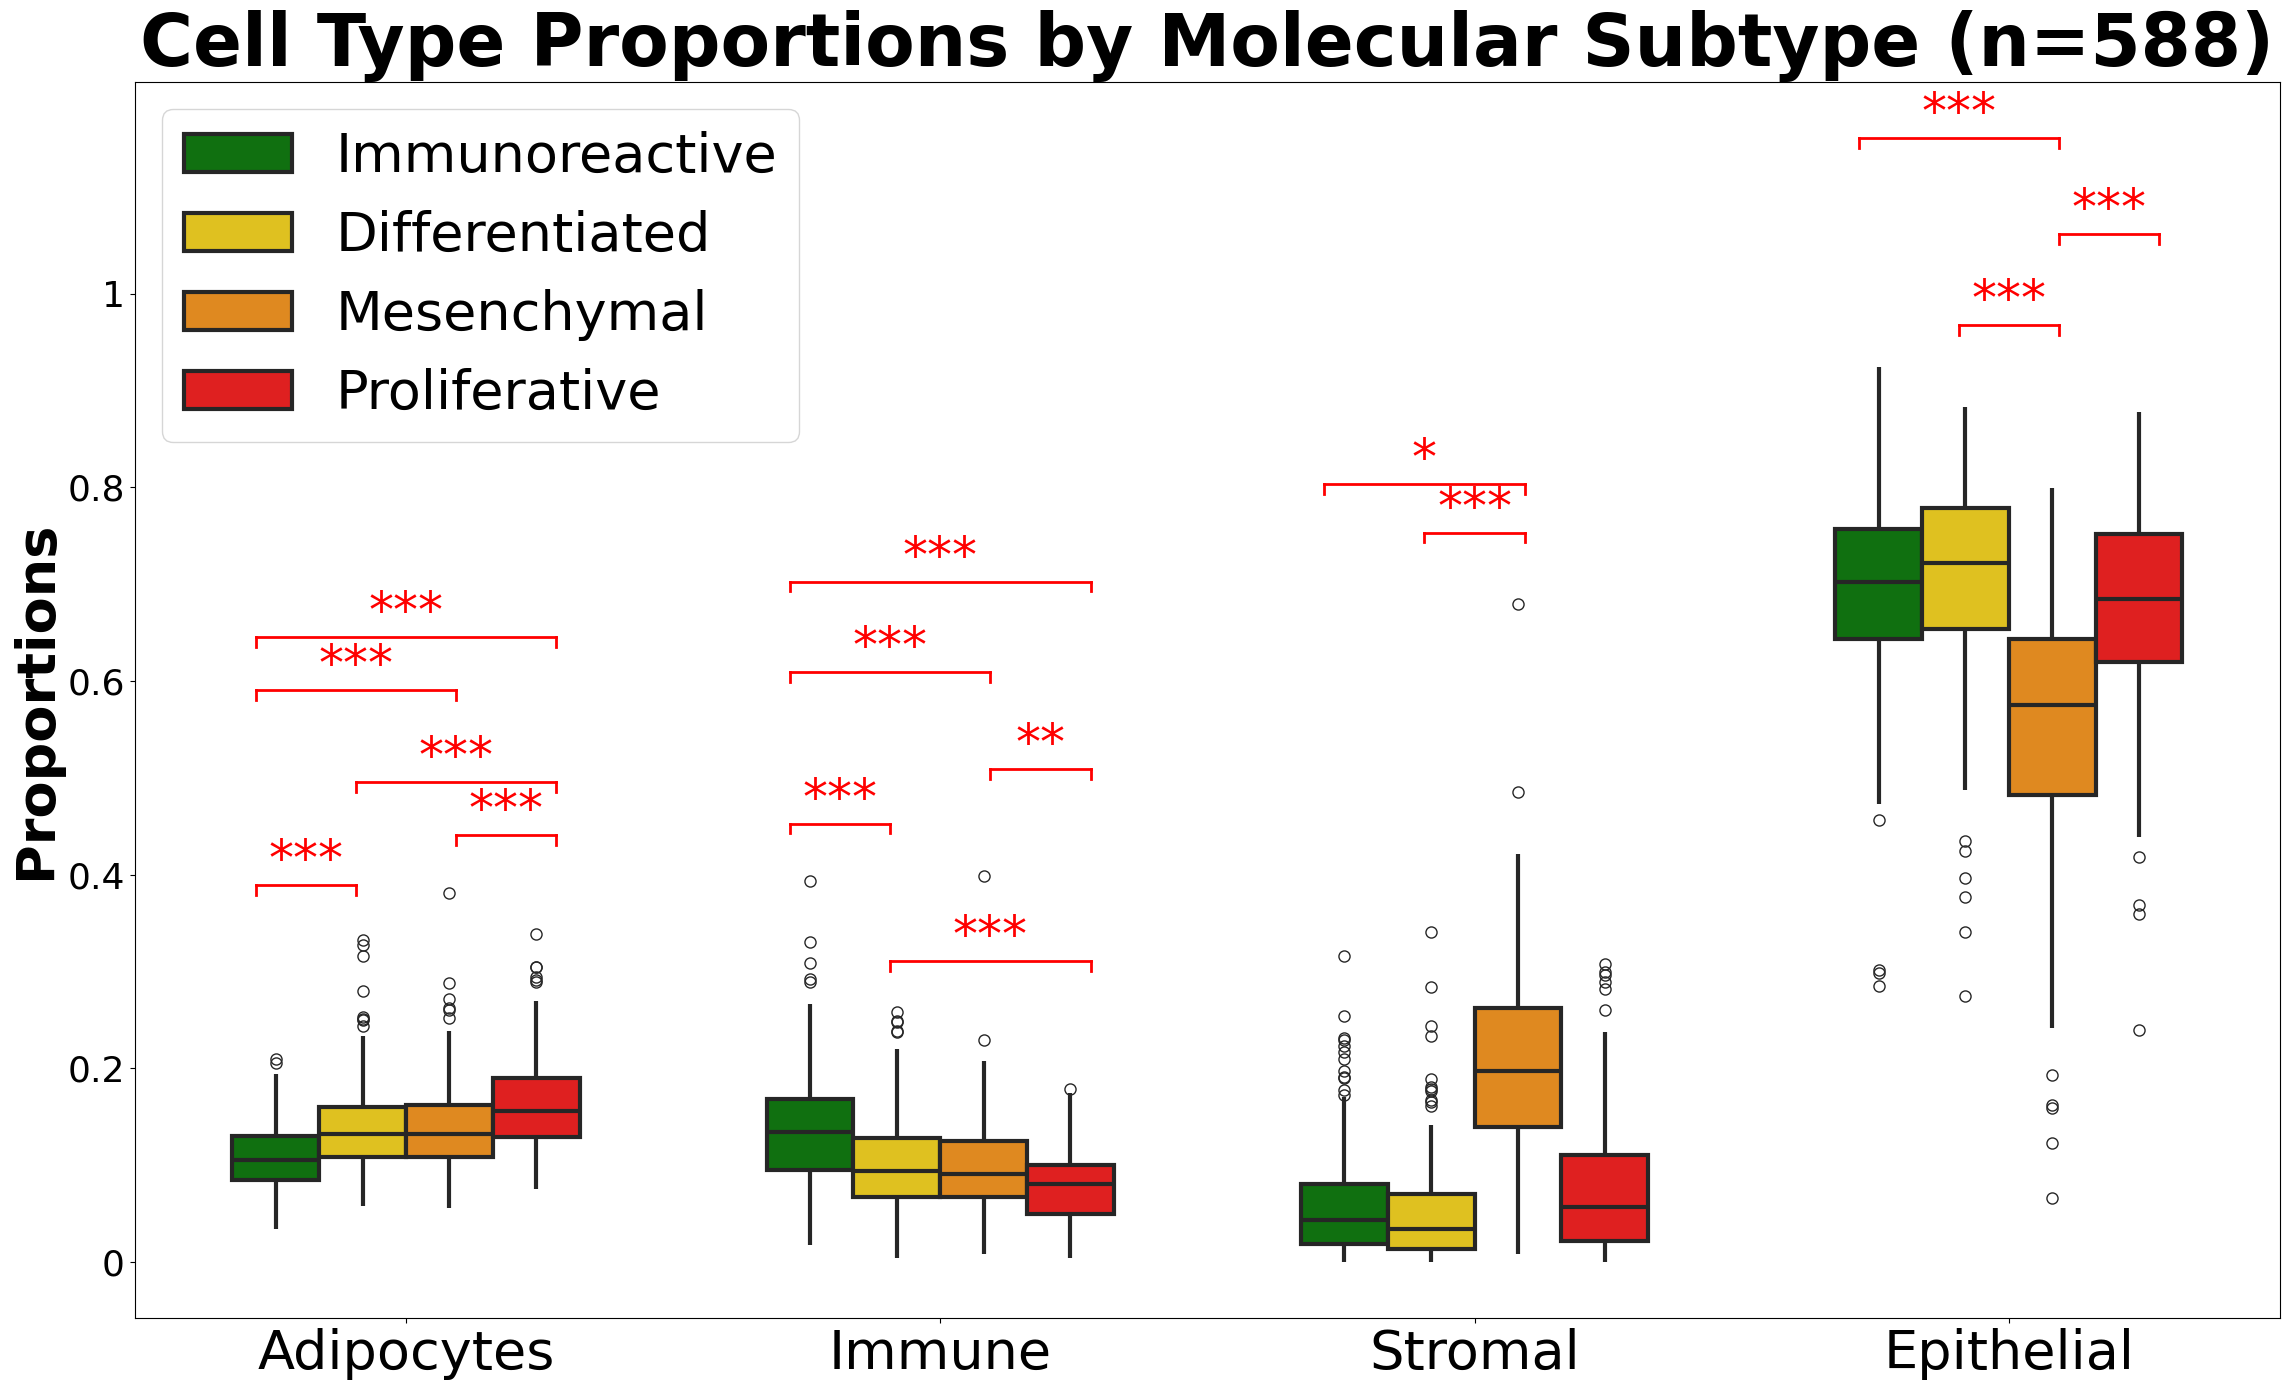

In [17]:
# ---------- plot ---------------------------------------------------------
palette = dict(zip(subtype_order, custom_colors))

plt.figure(figsize=(23, 14))
ax = sns.boxplot(
    data=long_all,
    x="Fraction",
    y="Prop",
    hue="Subtype",
    hue_order=subtype_order,
    palette=palette,
    width=0.65,
    linewidth=3,
    showcaps=False,
    fliersize=8,
)

# ---------- add brackets -------------------------------------------------
box_w = 0.75
inner_w = box_w / len(subtype_order)

for f_i, frac in enumerate(fractions):
    base_x = f_i - box_w / 2 + inner_w / 2
    tuk = tukey_dict[frac]

    # keep only sig. pairs, sort by |idx2−idx1| to draw short first
    sig = tuk[tuk["reject"] == True].copy()
    sig["span"] = sig.apply(
        lambda r: abs(
            subtype_order.index(r["group2"]) - subtype_order.index(r["group1"])
        ),
        axis=1,
    )
    sig = sig.sort_values("span")

    # Store bracket positions for overlap checking
    used_levels = []

    for _, row in sig.iterrows():
        g1, g2 = row["group1"], row["group2"]
        p_star = hp.p_to_star(float(row["p-adj"]))
        if not p_star:
            continue

        idx1, idx2 = subtype_order.index(g1), subtype_order.index(g2)
        x1 = base_x + idx1 * inner_w
        x2 = base_x + idx2 * inner_w

        y_max = long_all[
            (long_all.Fraction == frac) & (long_all.Subtype.isin([g1, g2]))
        ]["Prop"].max()
        y_base = y_max * 1.05 + 0.04

        # Find lowest level that doesn't overlap with existing brackets
        vstep = 0.05  # vertical spacing between bracket levels
        for level in itertools.count():
            y_brk = y_base + vstep * level
            overlaps = any(abs(y_brk - y) < 0.05 for y in used_levels)
            if not overlaps:
                used_levels.append(y_brk)
                break

        # Draw bracket
        ax.plot([x1, x2], [y_brk, y_brk], color="red", lw=2)
        ax.plot([x1, x1], [y_brk, y_brk - 0.01], color="red", lw=2)
        ax.plot([x2, x2], [y_brk, y_brk - 0.01], color="red", lw=2)
        ax.text(
            (x1 + x2) / 2,
            y_brk + 0.0001,
            p_star,
            ha="center",
            va="bottom",
            color="red",
            fontsize=36,
        )

# ---------- cosmetics ----------------------------------------------------
ax.set_ylabel("Proportion", fontsize=26)
ax.set_xlabel("")
ax.set_title(
    "Adipocyte, Immune and Stromal fractions by molecular subtype\n"
    "(Tukey HSD: *, **, ***)",
    fontsize=28,
    weight="bold",
)
ax.tick_params(axis="both", labelsize=20)
ax.legend(title="", fontsize=45, loc="best")
plt.tight_layout()
plt.ylabel("Proportions", fontsize=39, fontweight="bold")
plt.xlabel("", fontsize=39)
plt.title(
    f"Cell Type Proportions by Molecular Subtype (n={df.shape[0]})",
    fontsize=52,
    fontweight="bold",
)
plt.legend(title="", fontsize=39, loc="upper left")
plt.xticks(fontsize=39)
plt.yticks(
    ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=[0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=26
)
plt.tight_layout()
plt.show()